In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sklearn import preprocessing
from scipy.sparse.linalg import svds
from sklearn.manifold import TSNE
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression
import seaborn as sns
import lightgbm as lgb
%matplotlib inline

In [2]:
fund_stat = pd.read_excel("fund_name_risk.xlsx")

In [3]:
fund_stat["std"].mean()

0.06646084326054935

In [4]:
# fill nan with mean
fund_stat["std"][fund_stat["std"]==0] = fund_stat["std"].mean()

c:\users\thtang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# fund_stat_clean = fund_stat[fund_stat["std"] != 0].reset_index(drop=True)

In [6]:
fund_std_dict = {}
for index, row in fund_stat.iterrows():
    fund_std_dict[row["name"]] = row["std"]

# load invest data

In [7]:
invest = pd.read_excel("invest_data.xlsx")
invest.shape

(5820, 5)

In [8]:
invest_clean = invest[invest["金額"] != 0].reset_index(drop=True)

In [9]:
invest_clean.shape

(5146, 5)

In [10]:
max_ans_dict = pickle.load(open("./max_ans_dict.pkl","rb"))
uid_feature_dict = pickle.load(open("./uid_feature_dict.pkl","rb"))

In [11]:
quest_feautre_name = [q_id + "_" + str(n+1)for q_id in max_ans_dict.keys() for n in range(max_ans_dict[q_id])]
print("number of features:", len(quest_feautre_name))

number of features: 121


In [12]:
feature_matrix = []
for index, row in invest_clean.iterrows():
    uid = row["客戶"]
    feature_matrix.append(uid_feature_dict[uid])

In [13]:
feature_df = pd.DataFrame(feature_matrix)
feature_df.columns = quest_feautre_name

In [14]:
merge_df = pd.concat([invest_clean, feature_df],
                     sort=False, 
                     ignore_index=True, axis=1,
                    )
merge_df.columns = list(invest_clean.columns) + list(feature_df.columns)

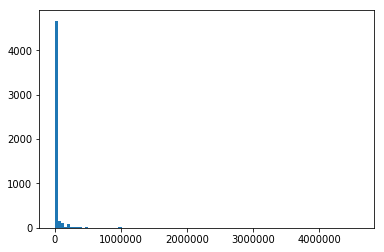

In [15]:
plt.hist(merge_df["金額"], bins=100)
plt.show()

In [16]:
# merge_df.to_csv("./data_df.csv", index=False, encoding="big5")

In [ ]:
# # (todo) create real value gound truth

# def softmax(x):
#     exp_x = np.exp(x)
#     softmax_x = exp_x / np.sum(exp_x)
#     return softmax_x 

# amount = np.array(merge_df["金額"]).reshape(len(merge_df["金額"]),1)

# robust_scale(amount).flatten().min()

# softmax(robust_scale(amount).flatten()


# create user_item interaction matrix

In [18]:
item_le = preprocessing.LabelEncoder()
fund_encoding = item_le.fit_transform(merge_df["基金簡稱"])
merge_df["item_id"] = fund_encoding

user_le = preprocessing.LabelEncoder()
user_encoding = user_le.fit_transform(merge_df["客戶"])
merge_df["user_id"] = user_encoding

In [29]:
user_le.classes_

array([   124,    178,    404, ..., 319475, 319528, 319550], dtype=int64)

In [30]:
user_encoding

array([183, 183, 183, ..., 181, 182, 182], dtype=int64)

In [19]:
# create user_item matrix
interaction_matrix = np.zeros((len(user_le.classes_),len(item_le.classes_)))
print("matrix size:", interaction_matrix.shape)

matrix size: (1462, 83)


In [20]:
for index, row in merge_df.iterrows():
    item_index = merge_df["item_id"]
    user_index = merge_df["user_id"]
    interaction_matrix[user_index, item_index] = 1

# SVD

In [21]:
latent = 50 # rank
U, Sigma, Vt = svds(interaction_matrix, k=latent)

### visualization 

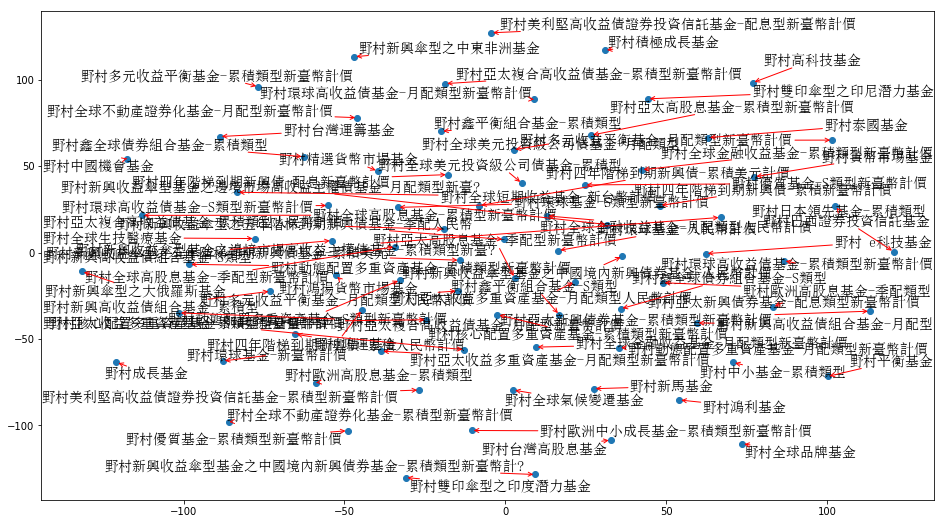

In [22]:
from matplotlib.font_manager import FontProperties # 步驟一
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14) # 步驟二

tsne = TSNE(n_components=2, random_state=0, perplexity=64)
vis_data = tsne.fit_transform(Vt.T)

plt.figure(figsize=(16,9))
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(vis_data[:,0], vis_data[:,1])
texts = [plt.text(vis_data[:,0][i], vis_data[:,1][i], 
                  words, ha='center', va='center', fontproperties=font) 
         for i, words in enumerate(item_le.classes_)]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
# plt.colorbar(ticks=range(18))
# plt.clim(-0.5, 17.5)
# plt.xlim(-40,40)
# plt.ylim(-40,40)
plt.show()

In [35]:
type(user_le.classes_[1])

numpy.int64

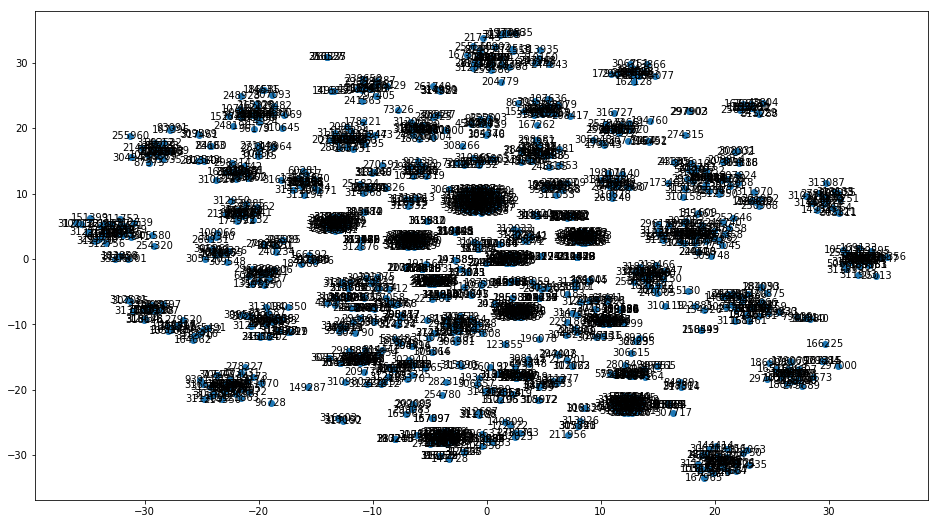

In [42]:
# (todo) 挑特徵上色
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
vis_data = tsne.fit_transform(U)


plt.figure(figsize=(16,9))

texts = [plt.text(vis_data[:,0][i], vis_data[:,1][i], 
                  str(words), ha='center', va='center') 
         for i, words in enumerate(user_le.classes_)]
# adjust_text(texts
# #             , arrowprops=dict(arrowstyle='->', color='red')
#            )

sc = plt.scatter(vis_data[:,0], vis_data[:,1])
plt.show()

# feature importance

add standardivation

In [19]:
std_list = []
for name in merge_df["基金簡稱"]:
    std_list.append(fund_std_dict[name])

In [20]:
merge_df["fund_std"] = std_list

計算每個 user 投資標的的平均 std

In [21]:
merge_df_user_group_mean = merge_df.groupby('客戶',as_index=False, sort=False).mean()
merge_df_user_group_mean

,客戶,金額,A0_1,A0_2,A0_3,A01_1,A01_2,A01_3,A01_4,A01_5,...,B06_4,B06_5,B07_1,B07_2,B07_3,B07_4,B07_5,item_id,user_id,fund_std
0,100066,46264.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,18.692308,183.0,0.101891
1,100542,3000.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,64.000000,184.0,0.118306
2,100558,4000.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.333333,185.0,0.170087
3,100606,3000.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.000000,186.0,0.126399
4,100657,5000.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,27.000000,187.0,0.112105
5,101140,14066.352941,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.352941,188.0,0.104128
6,105582,232249.285714,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,27.857143,206.0,0.071614
7,123855,121149.200000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.400000,229.0,0.132302
8,101150,35153.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,41.400000,189.0,0.098339
9,101275,12857.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,34.428571,190.0,0.154550


計算每個 user 投資標的的 weighted std

In [22]:
merge_df

,客戶,基金,基金簡稱,風險等級,金額,A0_1,A0_2,A0_3,A01_1,A01_2,...,B06_4,B06_5,B07_1,B07_2,B07_3,B07_4,B07_5,item_id,user_id,fund_std
0,100066,1,野村優質基金-累積類型新臺幣計價,RR4,3000,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,14,183,0.167070
1,100066,5,野村 e科技基金,RR5,36079,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,183,0.213087
2,100066,7,野村中小基金-累積類型,RR5,40000,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,183,0.170263
3,100066,9,野村全球高股息基金-累積型新臺幣計價,RR4,3000,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,27,183,0.112105
4,100066,37,野村全球生技醫療基金,RR4,9617,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,19,183,0.169309
5,100066,46,野村新興傘型之大俄羅斯基金,RR5,54273,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,44,183,0.066461
6,100066,48,野村中國機會基金,RR5,119385,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,183,0.180038
7,100066,49,野村全球美元投資級公司債基金-累積型,RR2,5000,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22,183,0.066461
8,100066,51,野村巴西證券投資信託基金,RR5,88041,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40,183,0.066461
9,100066,56,野村亞太複合高收益債基金-累積型新臺幣計價,RR4,3000,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9,183,0.030951


In [23]:
merge_df["weight_std"] = merge_df["fund_std"]*merge_df["金額"]

merge_df_user_group_sum = merge_df.groupby('客戶',as_index=False, sort=False).sum()

merge_df_user_group_sum["weight_std"] = merge_df_user_group_sum["weight_std"]/merge_df_user_group_sum["金額"]

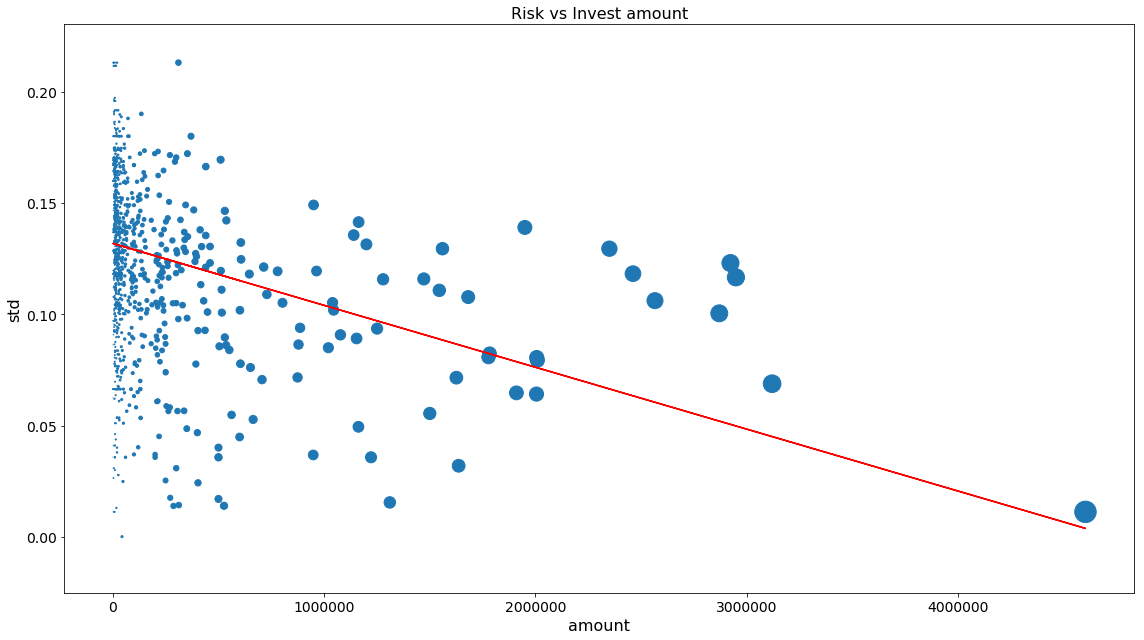

In [24]:
x, y = merge_df_user_group_sum["金額"], merge_df_user_group_mean["fund_std"]

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))  # perform linear regression
y_pred = linear_regressor.predict(np.array(x).reshape(-1, 1))  # make predictions

plt.figure(figsize=(16,9))
sc = plt.scatter(x, y, s=x/10000)
plt.title("Risk vs Invest amount", fontsize=16)
plt.xlabel("amount", fontsize=16)
plt.ylabel("std", fontsize=16)
plt.plot(x, y_pred, color='red')
plt.ylim(-0.025,)
plt.xticks(fontsize=14,)
plt.yticks(fontsize=14,)
plt.tight_layout()
plt.savefig("risk_amount.png", dpi=300)
plt.show()

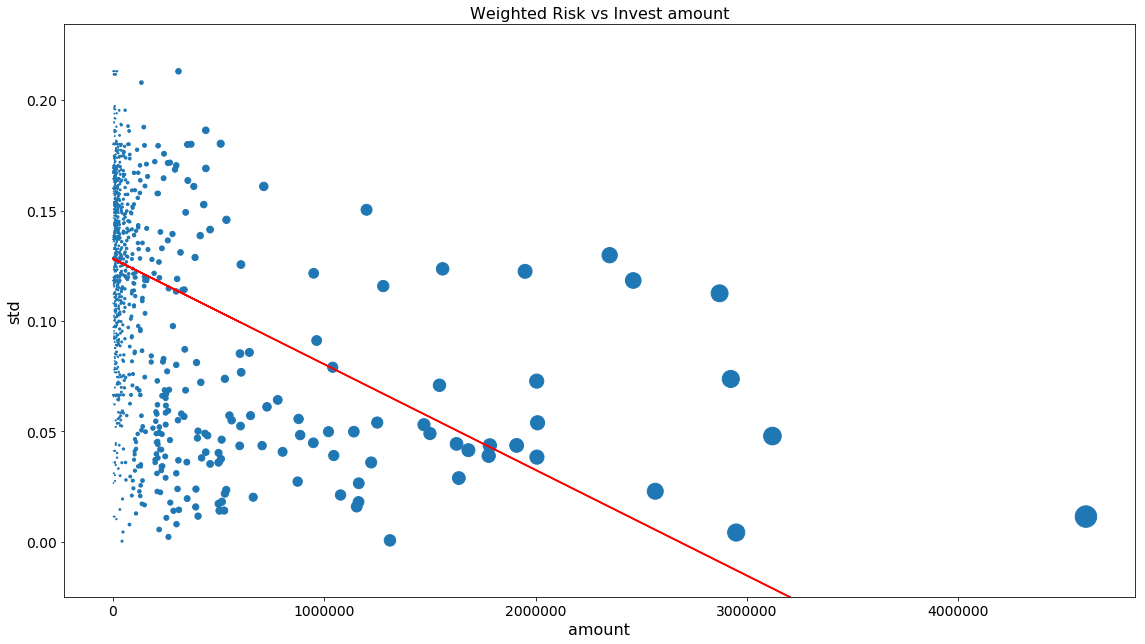

In [25]:
x, y = merge_df_user_group_sum["金額"], merge_df_user_group_sum["weight_std"]

# regression 
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))  # perform linear regression
y_pred = linear_regressor.predict(np.array(x).reshape(-1, 1))  # make predictions

plt.figure(figsize=(16,9))
# s = [20*4**n for amount in x]
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(x, y, s=x/10000)
plt.title("Weighted Risk vs Invest amount", fontsize=16)
plt.xlabel("amount", fontsize=16)
plt.ylabel("std", fontsize=16)
plt.plot(x, y_pred, color='red')
plt.tight_layout()
plt.ylim(-0.025,)
plt.xticks(fontsize=14,)
plt.yticks(fontsize=14,)
plt.savefig("weighted_risk_amount.png", dpi=300)
plt.show()

### create training df

In [26]:
training_df = merge_df_user_group_mean.drop(columns=['user_id', 'item_id',"客戶"])

In [27]:
training_df["total_investment"] = merge_df_user_group_sum["金額"]
training_df["weight_std"] = merge_df_user_group_sum["weight_std"]

In [36]:
X = training_df.drop(columns=['fund_std',"weight_std","total_investment","金額"])
# X.columns = ["mean_investment"] + list(X.columns[1:])
y_mean = training_df['fund_std']
y_weighted = training_df['weight_std']

In [37]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X,y_weighted)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### display feature importance

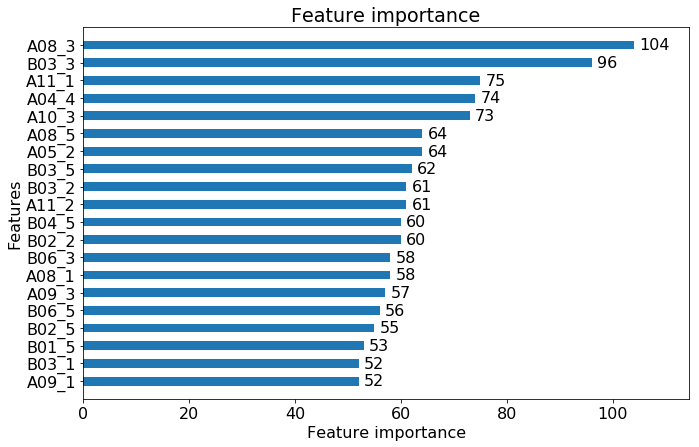

In [38]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
lgb.plot_importance(lgb_reg,figsize=(10,6.5),height=0.5,grid=False, max_num_features=20)
plt.tight_layout()
# plt.savefig("y_weight_feature_importance.png", dpi=300)
plt.show()

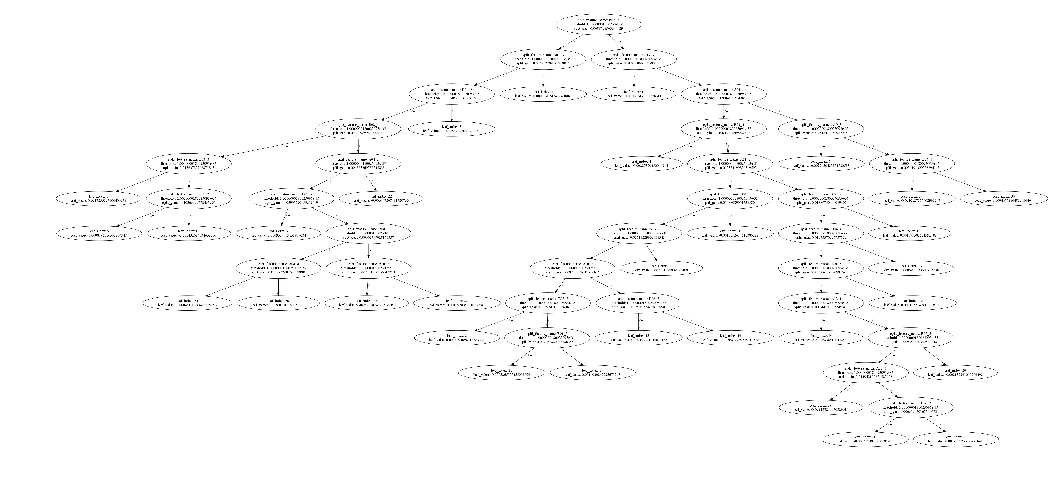

In [39]:
tree_index=3
lgb.plot_tree(lgb_reg, tree_index=tree_index, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [40]:
graph = lgb.create_tree_digraph(lgb_reg, tree_index=tree_index, name='Tree{}'.format(tree_index))
graph.render(view=True)

'Tree3.gv.pdf'

In [351]:
pd.DataFrame({"feauture":X.columns, "importance":lgb_reg.feature_importances_}).sort_values(["importance"], ascending=False)

,feauture,importance
0,mean_investment,518
122,total_investment,400
74,A11_2,71
70,A10_3,70
54,A08_3,68
40,A04_4,62
99,B03_3,52
73,A11_1,51
96,B02_5,50
101,B03_5,50


In [317]:
print("features ranked by importance:",list([sorted_col_index])[:-useless_feature_count])

features ranked by importance: ['金額', 'total_investment', 'A11_2', 'A10_3', 'A08_3', 'A04_4', 'B03_3', 'A11_1', 'B02_5', 'B03_5', 'A09_3', 'B04_5', 'B07_5', 'A02_1', 'B03_2', 'A05_2', 'A08_1', 'A08_5', 'B02_2', 'B05_3', 'B01_4', 'B06_4', 'B02_4', 'B02_3', 'B05_4', 'A02_2', 'A02_7', 'B06_3', 'A08_4', 'A04_5', 'A09_1', 'A09_2', 'B01_5', 'A11_3', 'B04_3', 'A04_3', 'A01_4', 'A05_3', 'B06_5', 'A09_4', 'B01_3', 'B03_1', 'B04_4', 'A04_2', 'B07_3', 'A01_3', 'A10_1', 'A05_1', 'A01_5', 'A01_6', 'A01_7', 'B02_1', 'A10_2', 'A12_1', 'A12_2', 'B03_4', 'A13_1', 'A02_5', 'A06_6', 'A01_21', 'A08_6', 'B07_4', 'A10_5', 'A01_13', 'B05_5', 'A01_24', 'B04_2', 'B01_2', 'A14_4', 'B07_2', 'A09_8', 'A01_2', 'A01_8', 'A06_1', 'A08_2', 'B01_1', 'A02_6', 'A09_7', 'A09_6', 'A01_1', 'A02_4', 'A10_4', 'B06_2', 'A14_1', 'A12_3', 'B07_1', 'A13_2', 'A01_14', 'A02_3', 'A04_1', 'A06_2']


In [291]:
dftrainLGB = lgb.Dataset(data = X, label = y_mean, feature_name = list(X.columns))

In [293]:
params = {'objective': 'regression'}

cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        # This is what I added
        stratified=False
        )